## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from IPython import display

In [2]:
import sys
sys.path.append('../')
from src.models.convolutional_variational_autoencoder import IWAE, IWAE_MLMC

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Training and visualization

In [7]:
def train_epoch(model, train_dataset, loss):
    for train_x in train_dataset:
        model.train_step(train_x, loss=loss)

def train_and_plot(model, train_dataset, test_dataset, epochs = 10, loss='elbo'):
    num_examples_to_generate = 16

    # keeping the random vector constant for generation (prediction) so
    # it will be easier to see the improvement.
    random_vector_for_generation = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])

    # Pick a sample of the test set for generating output images
    assert batch_size >= num_examples_to_generate
    for test_batch in test_dataset.take(1):
        test_sample = test_batch[0:num_examples_to_generate, :, :, :]

    model.generate_images(0, test_sample)
    plt.show()

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        train_epoch(model, train_dataset, loss)
        end_time = time.time()

        elbo = np.mean([model.compute_elbo(test_x) for test_x in test_dataset])
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                .format(epoch, elbo, end_time - start_time))
        model.generate_images(epoch, test_sample)
        # tight_layout minimizes the overlap between 2 sub-plots
        #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

In [34]:
def plot_convergence(model, test_dataset):
    tmp_dataset = (tf.data.Dataset.from_tensor_slices(test_images[:100])
                    .shuffle(100).batch(1))
    def get_L2_norm(L):
        diwelbos = [model._compute_diwelbos(x, L) for x in tmp_dataset]
        return sum(np.array(diwelbos)**2/100)**0.5
    
    levels = np.arange(10)
    res = [get_L2_norm(l) for l in levels]
    plt.plot([2**l for l in levels], res)
    plt.plot([2**l for l in levels], [res[1]*2.**(0.75-l) for l in levels], c='gray')
    plt.plot([2**l for l in levels], [res[1]*2.**(0.75-0.5*l) for l in levels], c='gray')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend([r'$\sqrt{E[(\Delta IWELBO)^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-\ell/2})$'])

In [35]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 3
model = IWAE_MLMC(latent_dim)

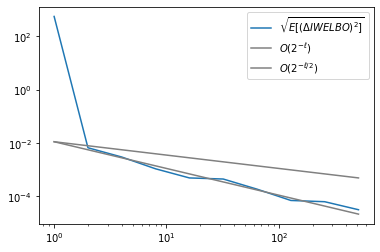

In [36]:
plot_convergence(model, test_dataset)

Epoch: 10, Test set ELBO: -137.54885864257812, time elapse for current epoch: 39.0006890296936


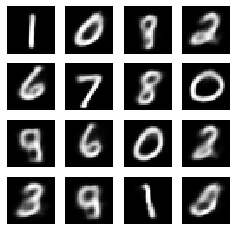

In [14]:
train_and_plot(model, train_dataset, test_dataset, epochs=10)

In [15]:
np.mean([model.compute_iwelbo(x_test, K=64) for x_test in test_dataset])

-133.26532

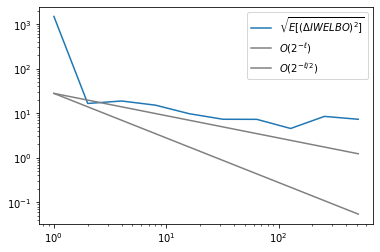

In [16]:
plot_convergence(model, test_dataset)

In [37]:
def plot_convergence_grad(model, test_dataset):
    tmp_dataset = (tf.data.Dataset.from_tensor_slices(test_images[:100])
                    .shuffle(100).batch(1))
    
    def get_grad(x, L):
        with tf.GradientTape() as tape:
            loss =  - model._compute_diwelbos(x, L)
            gradients = tape.gradient(loss, model._decoder.trainable_variables)
        return gradients
    
    def get_L2_norm(L):
        L2 = 0
        for x in tmp_dataset:
            L2 += get_grad(x, L)**2
        return sum(L2/100)**0.5
    
    levels = np.arange(10)
    res = [get_L2_norm(l) for l in levels]
    plt.plot([2**l for l in levels], res)
    plt.plot([2**l for l in levels], [res[1]*2.**(0.75-l) for l in levels], c='gray')
    plt.plot([2**l for l in levels], [res[1]*2.**(0.75-0.5*l) for l in levels], c='gray')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend([r'$\sqrt{E[||\Delta \nabla IWELBO||_2^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-\ell/2})$'])

In [38]:
plot_convergence_grad(model, test_dataset)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'